In [ ]:
# Install necessary packages (only needed if not already installed)
!pip install nilearn
!pip install split-folders
!pip install segmentation_models_3D

In [ ]:
# Import required libraries for data processing, visualization, and model building
import os
import glob
import keras
import random
import numpy as np
import splitfolders  
import pandas as pd
import nilearn as nl
import nibabel as nib
import matplotlib.pyplot as plt
import nilearn.plotting as nlplt
import segmentation_models_3D as sm

from keras.metrics import MeanIoU
from keras.optimizers import Adam
from nilearn import image, plotting 
from keras.models import Model, load_model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from keras.layers import (
    Input, Conv3D, MaxPooling3D, concatenate,
    Conv3DTranspose, BatchNormalization, Dropout, Lambda
) 

# Initialize scaler
scaler = MinMaxScaler()

Segmentation Models: using `keras` framework.


In [3]:
# Define paths to training and validation datasets
# train_dataset_dir = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
# validation_dataset_dir = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

train_dataset_dir = 'E:\BraTS-Dataset\BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
validation_dataset_dir = 'E:\BraTS-Dataset/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

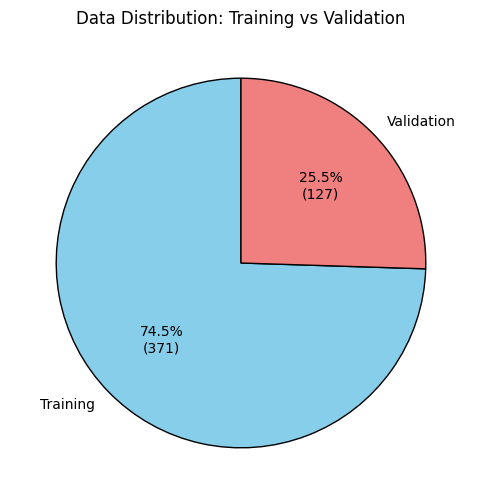

In [4]:
# Count the number of training and validation samples and visualize the distribution  
train_img_list = len(os.listdir(train_dataset_dir))
val_img_list = len(os.listdir(validation_dataset_dir))

# Labels and sizes for the pie chart  
labels = ['Training', 'Validation']
sizes = [train_img_list, val_img_list]
colors = ['skyblue', 'lightcoral']

# Function to format percentage and absolute values  
def autopct_format(pct, all_vals):
    absolute = int(round(pct / 100. * sum(all_vals)))
    return f"{pct:.1f}%\n({absolute})"

# Plot the dataset distribution  
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct=lambda pct: autopct_format(pct, sizes),
        colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title('Data Distribution: Training vs Validation')
plt.show()

In [5]:
# Load and normalize MRI modalities for a sample patient  
sample_to_use = 'BraTS20_Training_020'
sample_dir = train_dataset_dir + f"{sample_to_use}/{sample_to_use}"

# Load FLAIR modality and normalize  
test_image_flair = nib.load(f"{sample_dir}_flair.nii").get_fdata() 
test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

# Load and normalize other MRI modalities  
test_image_t1 = nib.load(f"{sample_dir}_t1.nii").get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce = nib.load(f"{sample_dir}_t1ce.nii").get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2 = nib.load(f"{sample_dir}_t2.nii").get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# Load and process segmentation mask  
test_mask = nib.load(f"{sample_dir}_seg.nii").get_fdata().astype(np.uint8)

# Print unique values in the mask before and after remapping label 4 to 3  
print(np.unique(test_mask))
test_mask[test_mask == 4] = 3  
print(np.unique(test_mask))

[0 1 2 4]
[0 1 2 3]


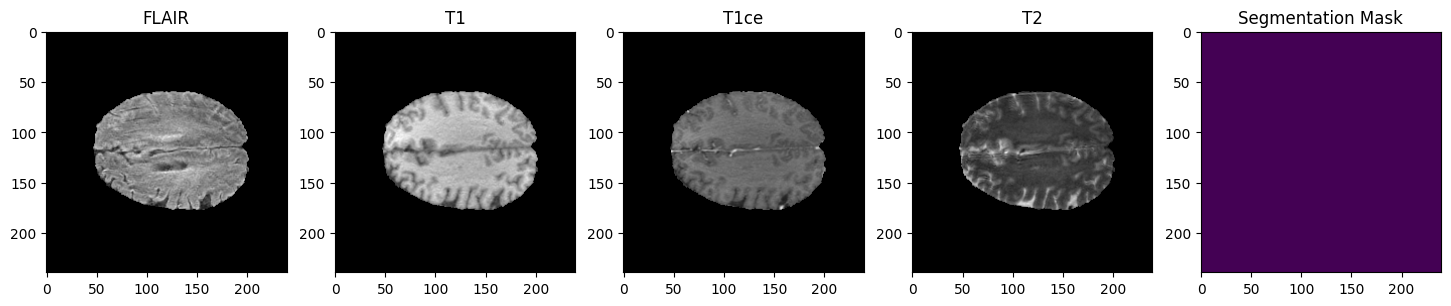

In [6]:
# Randomly select a slice and visualize different MRI modalities and the segmentation mask in a single row  
n_slice = random.randint(0, test_mask.shape[2])

plt.figure(figsize=(18, 6)) 

# Plot the modalities and segmentation mask
plt.subplot(151)  # 1 row, 5 columns, first plot
plt.imshow(test_image_flair[:, :, n_slice], cmap='gray')
plt.title('FLAIR')

plt.subplot(152)  # 1 row, 5 columns, second plot
plt.imshow(test_image_t1[:, :, n_slice], cmap='gray')
plt.title('T1')

plt.subplot(153)  # 1 row, 5 columns, third plot
plt.imshow(test_image_t1ce[:, :, n_slice], cmap='gray')
plt.title('T1ce')

plt.subplot(154)  # 1 row, 5 columns, fourth plot
plt.imshow(test_image_t2[:, :, n_slice], cmap='gray')
plt.title('T2')

plt.subplot(155)  # 1 row, 5 columns, fifth plot
plt.imshow(test_mask[:, :, n_slice])
plt.title('Segmentation Mask')

plt.show()

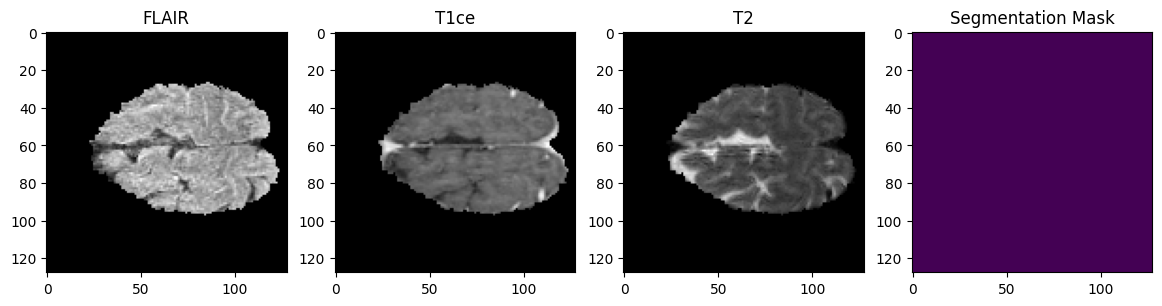

In [7]:
# Stack selected MRI modalities along the channel dimension and crop to 128x128x128  
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)
combined_x = combined_x[56:184, 56:184, 13:141]  # Crop to 128x128x128  

# Crop the segmentation mask to match  
test_mask = test_mask[56:184, 56:184, 13:141]

# Select a random slice for visualization  
n_slice = random.randint(0, test_mask.shape[2])

# Plot the selected slice from different modalities and the segmentation mask in a single row  
plt.figure(figsize=(18, 6))  # Adjust figure size for horizontal layout

plt.subplot(151)  # 1 row, 5 columns, first plot
plt.imshow(combined_x[:, :, n_slice, 0], cmap='gray')
plt.title('FLAIR')

plt.subplot(152)  # 1 row, 5 columns, second plot
plt.imshow(combined_x[:, :, n_slice, 1], cmap='gray')
plt.title('T1ce')

plt.subplot(153)  # 1 row, 5 columns, third plot
plt.imshow(combined_x[:, :, n_slice, 2], cmap='gray')
plt.title('T2')

plt.subplot(154)  # 1 row, 5 columns, fourth plot
plt.imshow(test_mask[:, :, n_slice])
plt.title('Segmentation Mask')

plt.show()

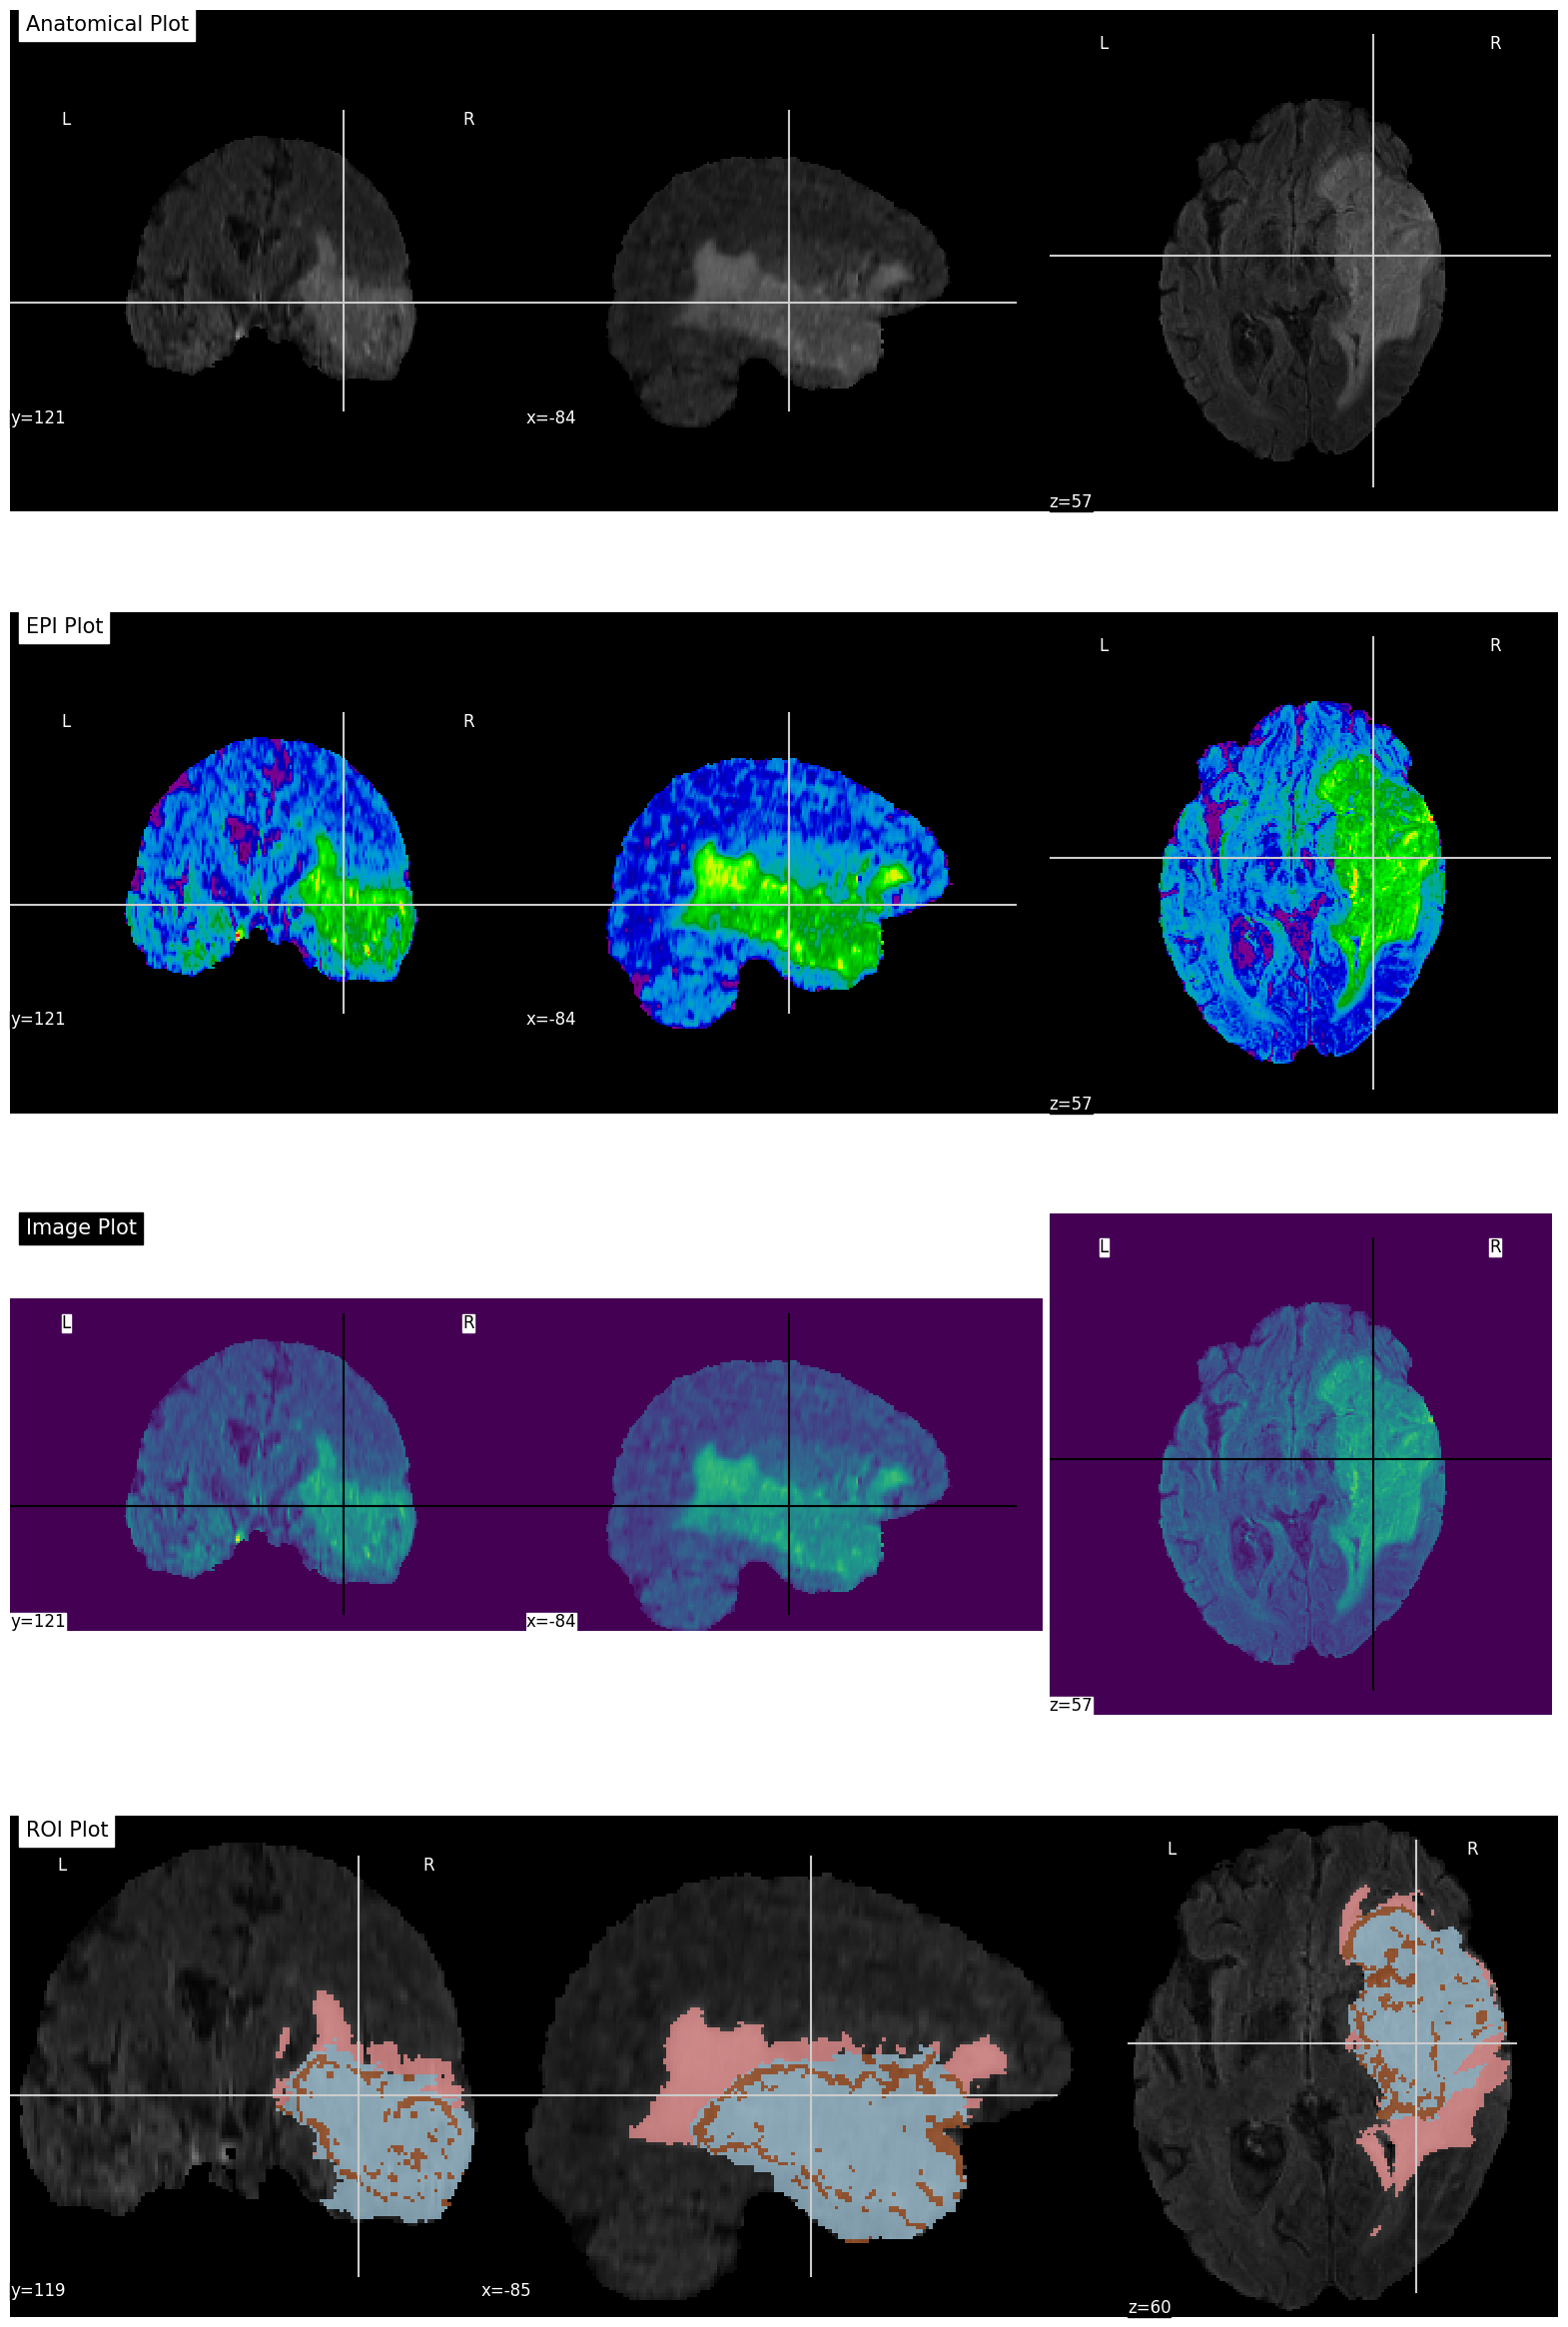

In [8]:
# Load the MRI images and segmentation mask using nilearn
niimg = image.load_img(f"{sample_dir}_flair.nii")
nimask = image.load_img(f"{sample_dir}_seg.nii")

# Create subplots to display various views of the MRI data
fig, axes = plt.subplots(nrows=4, figsize=(20, 30))

# Plot anatomical image
nlplt.plot_anat(niimg, title="Anatomical Plot", axes=axes[0])

# Plot the epi (epipolar) image
nlplt.plot_epi(niimg, title="EPI Plot", axes=axes[1])

# Plot the standard image (with MRI data)
nlplt.plot_img(niimg, title="Image Plot", axes=axes[2])

# Plot the region of interest (ROI) on top of the anatomical image
nlplt.plot_roi(
    nimask,
    title="ROI Plot",
    bg_img=niimg,  # Background anatomical image
    axes=axes[3],
    cmap="Paired",
)  # Color map for segmentation mask

# Show the plot
plt.show()

In [9]:
# Define expected file suffixes for validation and training datasets
expected_suffixes_validation = ['_t1.nii', '_t1ce.nii', '_t2.nii', '_flair.nii']
expected_suffixes_train = expected_suffixes_validation + ['_seg.nii']

# Function to check if all expected files are present in the directory
def check_files_in_directory(dir_path, dir_name, expected_suffixes):
    # Construct list of expected files
    expected_files = [f"{dir_name}{suffix}" for suffix in expected_suffixes]
    actual_files = os.listdir(dir_path)
    
    # Identify missing and extra files
    missing_files = set(expected_files) - set(actual_files)
    extra_files = set(actual_files) - set(expected_files)
    
    # Print messages if there are errors
    if missing_files:
        print(f"Directory {dir_name} is missing files: {missing_files}")
    if extra_files:
        print(f"Directory {dir_name} has unexpected files: {extra_files}")

# Function to process all directories in the dataset and check file integrity
def process_dataset(dataset_path, dataset_name, expected_suffixes):
    print(f"Checking directory: {dataset_name}")
    
    for dir_name in os.listdir(dataset_path):
        dir_path = os.path.join(dataset_path, dir_name)
        
        # Only process directories, skipping files
        if os.path.isdir(dir_path): 
            check_files_in_directory(dir_path, dir_name, expected_suffixes)
        else:
            print(f"Skipping non-directory: {dir_name}")

In [10]:
# Process the training dataset to check for expected files (including segmentation masks)
process_dataset(train_dataset_dir, "Training", expected_suffixes_train)

print("\n")

# Process the validation dataset to check for expected files (excluding segmentation masks)
process_dataset(validation_dataset_dir, "Validation", expected_suffixes_validation)

Checking directory: Training
Skipping non-directory: name_mapping.csv
Skipping non-directory: survival_info.csv


Checking directory: Validation
Skipping non-directory: name_mapping_validation_data.csv
Skipping non-directory: survival_evaluation.csv


In [ ]:
# No need to run this block as the file name has already been renamed

# Define the path to the specific training directory
dir_path = os.path.join(train_dataset_dir, 'BraTS20_Training_355')

# Specify the old and new file names
old_file_name = 'W39_1998.09.19_Segm.nii'
new_file_name = "BraTS20_Training_355_seg.nii" 

# Construct the full file paths
old_file_path = os.path.join(dir_path, old_file_name)
new_file_path = os.path.join(dir_path, new_file_name)

# Check if the old file exists and rename it
if os.path.exists(old_file_path):
    os.rename(old_file_path, new_file_path)
    print(f"Renamed {old_file_name} to {new_file_name}")
else:
    print(f"Error: The file {old_file_name} does not exist in {dir_path}.")

In [11]:
# Define the base directory for filtered data and its subdirectories

# combined_data_dir = '/kaggle/working/filtered_data/'
# combined_images_dir = os.path.join(combined_data_dir, "images/")
# combined_masks_dir = os.path.join(combined_data_dir, "masks/")

combined_data_dir = 'E:/BraTS-Dataset/combined_data'
combined_images_dir = os.path.join(combined_data_dir, "images/")
combined_masks_dir = os.path.join(combined_data_dir, "masks/")

# Define the base directory for splitted data
filtered_data_dir = 'E:/BraTS-Dataset/filtered_data/'

In [ ]:
# Create necessary directories if they don't already exist
os.makedirs(filtered_data_dir, exist_ok=True)  # Directory for splitted data
os.makedirs(combined_images_dir, exist_ok=True)  # Directory for filtered images
os.makedirs(combined_masks_dir, exist_ok=True)  # Directory for filtered masks

In [12]:
# Get sorted lists of MRI files and segmentation masks in the training dataset directory
t1_list = sorted(glob.glob(os.path.join(train_dataset_dir, '*/*t1.nii')))
t2_list = sorted(glob.glob(os.path.join(train_dataset_dir, '*/*t2.nii')))
t1ce_list = sorted(glob.glob(os.path.join(train_dataset_dir, '*/*t1ce.nii')))
flair_list = sorted(glob.glob(os.path.join(train_dataset_dir, '*/*flair.nii')))
mask_list = sorted(glob.glob(os.path.join(train_dataset_dir, '*/*seg.nii')))

# Print the length of each list to verify the number of files found
print("T1 list:", len(t1_list))
print("T2 list:", len(t2_list))
print("T1ce list:", len(t1ce_list))
print("Flair list:", len(flair_list))
print("Mask list:", len(mask_list))

T1 list: 369
T2 list: 369
T1ce list: 369
Flair list: 369
Mask list: 369


In [ ]:
# Iterate over the list of T2 images and process corresponding modalities and masks
for img in range(len(t2_list)):
    # Load and scale the T2 image
    temp_image_t2 = nib.load(t2_list[img]).get_fdata()
    temp_image_t2 = scaler.fit_transform(
        temp_image_t2.reshape(-1, temp_image_t2.shape[-1])
    ).reshape(temp_image_t2.shape)

    # Load and scale the T1ce image
    temp_image_t1ce = nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce = scaler.fit_transform(
        temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])
    ).reshape(temp_image_t1ce.shape)

    # Load and scale the FLAIR image
    temp_image_flair = nib.load(flair_list[img]).get_fdata()
    temp_image_flair = scaler.fit_transform(
        temp_image_flair.reshape(-1, temp_image_flair.shape[-1])
    ).reshape(temp_image_flair.shape)

    # Load the mask and process the label values
    temp_mask = nib.load(mask_list[img]).get_fdata()
    temp_mask = temp_mask.astype(np.uint8)
    temp_mask[temp_mask == 4] = 3  # Reassign mask value 4 to 3 to match the label

    # Combine the images into a single array (shape: x, y, z, modalities)
    temp_combined_images = np.stack(
        [temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3
    )

    # Crop the images and mask to the region of interest (128x128x128)
    temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]

    # Count unique values in the mask
    val, counts = np.unique(temp_mask, return_counts=True)

    # Check if there is at least 1% non-background volume in the mask
    if (1 - (counts[0] / counts.sum())) > 0.01:
        # Save the processed images and masks as .npy files if valid
        print(f"Saving image and mask {img}")
        temp_mask = to_categorical(temp_mask, num_classes=4)
        np.save(
            os.path.join(combined_images_dir, f"image_{img}.npy"),
            temp_combined_images,
        )
        np.save(
            os.path.join(combined_masks_dir, f"mask_{img}.npy"),
            temp_mask,
        )
    else:
        # Print a message if the mask doesn't contain enough useful volume
        print(f"Something wrong with image and mask number: {img}")


In [ ]:
# Skip as already been splitted

# Split the data from the combined data directory into training and validation sets
# using a 75% (training) and 25% (validation) ratio, with a fixed seed for reproducibility.
splitfolders.ratio(
    combined_data_dir,  
    filtered_data_dir,   
    seed=42,             
    ratio=(.75, .25),    
    group_prefix=None   
)

In [13]:
# Function to load images from a given directory based on a list of image names
def load_img(img_dir, img_list):
    images = []
    
    # Loop over the image names in the provided list
    for image_name in img_list:
        # Check if the file is a .npy file
        if image_name.split(".")[-1] == "npy":  
            # Load the image as a numpy array
            image = np.load(os.path.join(img_dir, image_name))
            images.append(image)
    
    # Convert the list of images into a numpy array and return
    images = np.array(images)
    return images

# Custom data generator for loading images and masks in batches
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
    L = len(img_list)
    
    # Infinite loop to keep yielding batches indefinitely
    while True:
        batch_start = 0
        batch_end = batch_size
        
        # Loop to load batches of data until the entire dataset is processed
        while batch_start < L:
            # Ensure the batch doesn't exceed the total number of images
            limit = min(batch_end, L)
            
            # Load the images and corresponding masks for the current batch
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])
            
            # Yield a batch (X, Y) to the model
            yield (X, Y)
            
            # Move to the next batch
            batch_start += batch_size
            batch_end += batch_size

In [ ]:
kernel_initializer =  'he_uniform'

def build_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    # Input layer
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    # Output layer
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    # Create the model 
    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [14]:
# Define the directory paths for training and validation images and masks

# train_img_dir = "/kaggle/input/filtered-data/splitted_data/train/images/"
# train_mask_dir = "/kaggle/input/filtered-data/splitted_data/train/masks/"

# val_img_dir = "/kaggle/input/filtered-data/splitted_data/val/images/"
# val_mask_dir = "/kaggle/input/filtered-data/splitted_data/val/masks/"

train_img_dir = "E:/BraTS-Dataset/filtered_data/train/images/"
train_mask_dir = "E:/BraTS-Dataset/filtered_data/train/masks/"

val_img_dir = "E:/BraTS-Dataset/filtered_data/val/images/"
val_mask_dir = "E:/BraTS-Dataset/filtered_data/val/masks/"

In [15]:
# Count files in the training directory
train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

# Count files in the validation directory
val_img_list = os.listdir(val_img_dir)   
val_mask_list = os.listdir(val_mask_dir)

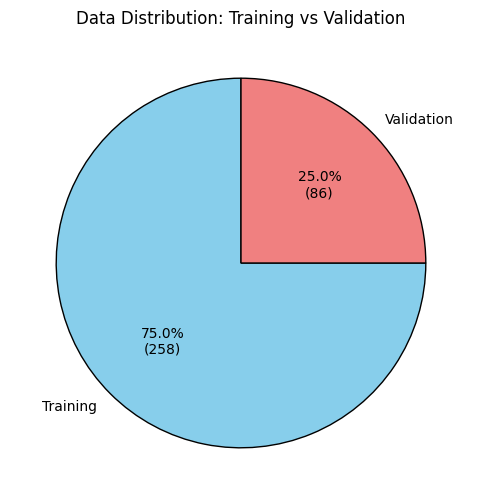

In [16]:
# Labels and data for the pie chart
labels = ['Training', 'Validation']
sizes = [len(train_img_list), len(val_img_list)]
colors = ['skyblue', 'lightcoral']

def autopct_format(pct, all_vals):
    absolute = int(round(pct / 100. * sum(all_vals)))
    return f"{pct:.1f}%\n({absolute})"

# Create and display the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct=lambda pct: autopct_format(pct, sizes),
        colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title('Data Distribution: Training vs Validation')
plt.show()


In [17]:
# Define the batch size 
batch_size = 2

# create the data generators for training images and masks
train_img_datagen = imageLoader(
    train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size
)

# create the data generators for validation images and masks
val_img_datagen = imageLoader(
    val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size
)

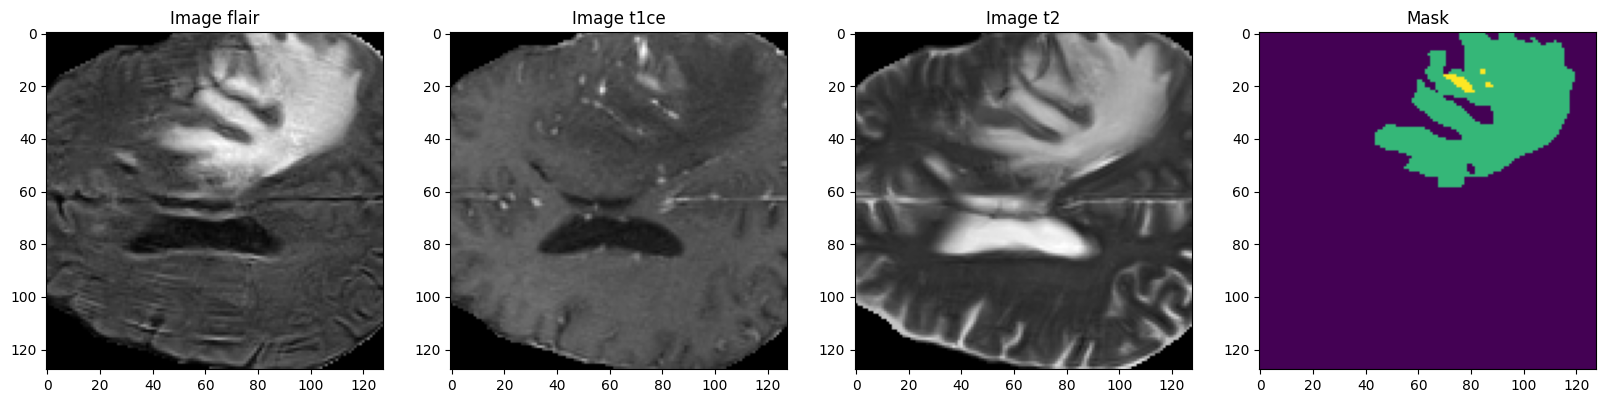

In [20]:
# Assuming train_img_datagen is already defined and provides batches of images and masks
img, msk = train_img_datagen.__next__()  # Fetch a batch of images and masks from the generator

# Randomly select an image from the batch
img_num = random.randint(0, img.shape[0] - 1)  
test_img = img[img_num]  # Selected image
test_mask = msk[img_num]  # Corresponding mask
test_mask = np.argmax(test_mask, axis=3)  # Convert one-hot mask to label map

# Select a random slice from the image
n_slice = random.randint(0, test_mask.shape[2])  # Choose a random slice index

# Plot selected slices from the image and its mask in a single row
plt.figure(figsize=(20, 5))  # Adjust figure size for a single row layout

plt.subplot(141)  # First plot (1 row, 4 columns)
plt.imshow(test_img[:, :, n_slice, 0], cmap="gray")  # FLAIR image
plt.title("Image flair")

plt.subplot(142)  # Second plot (1 row, 4 columns)
plt.imshow(test_img[:, :, n_slice, 1], cmap="gray")  # T1ce image
plt.title("Image t1ce")

plt.subplot(143)  # Third plot (1 row, 4 columns)
plt.imshow(test_img[:, :, n_slice, 2], cmap="gray")  # T2 image
plt.title("Image t2")

plt.subplot(144)  # Fourth plot (1 row, 4 columns)
plt.imshow(test_mask[:, :, n_slice])  # Segmentation mask
plt.title("Mask")

plt.show()

In [ ]:
# Define loss functions, metrics, and optimizer to be used for training the model
wt0, wt1, wt2, wt3 = 0.25, 0.25, 0.25, 0.25  # Set class weights for loss functions

# Dice Loss with class weights
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))

# Focal Loss for categorical data
focal_loss = sm.losses.CategoricalFocalLoss()

# Combine Dice Loss and Focal Loss for total loss function
total_loss = dice_loss + (1 * focal_loss)

# Metrics to monitor during training
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]  

# Learning rate and optimizer
LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Define the number of steps per epoch for training and validation
steps_per_epoch = len(train_img_list) // batch_size
val_steps_per_epoch = len(val_img_list) // batch_size

In [ ]:
# Build and compile the model, then print its summary and shapes

# Initialize the model with input dimensions (128x128x128x3) and 4 output classes
model = build_model(IMG_HEIGHT=128, 
                    IMG_WIDTH=128, 
                    IMG_DEPTH=128, 
                    IMG_CHANNELS=3, 
                    num_classes=4)

# Compile the model with the previously defined optimizer, loss functions, and metrics
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)

# Print model summary and input/output shapes for verification
print(model.summary())  # Shows a summary of the model architecture
print(model.input_shape)  # Prints the shape of the input layer
print(model.output_shape)  # Prints the shape of the output layer

In [ ]:
# Train the model
history = model.fit(
    train_img_datagen,  # The training data generator
    steps_per_epoch=steps_per_epoch,  # Number of steps per epoch (batch iterations per epoch)
    epochs=35,  # Number of epochs to train the model
    verbose=1,  # Display the progress of training (1 means a progress bar)
    validation_data=val_img_datagen,  # The validation data generator
    validation_steps=val_steps_per_epoch,  # Number of validation steps per epoch
)

# Save the trained model
# The model is saved in HDF5 format so it can be easily loaded later for inference or continued training.
# model.save("/kaggle/working/My_Computing_Project_Model.hdf5")
model.save("./My_Computing_Project_Model.h5")

# Confirmation message for saving the model
print("Model training completed and saved as 'My_Computing_Project_Model.h5'")

In [21]:
# Load your model
model = load_model(
    "./My_Computing_Project_Model.h5",
    compile=False,
)

# Plot training and validation loss
history = pd.read_csv('./training_data.log', sep=',', engine='python')

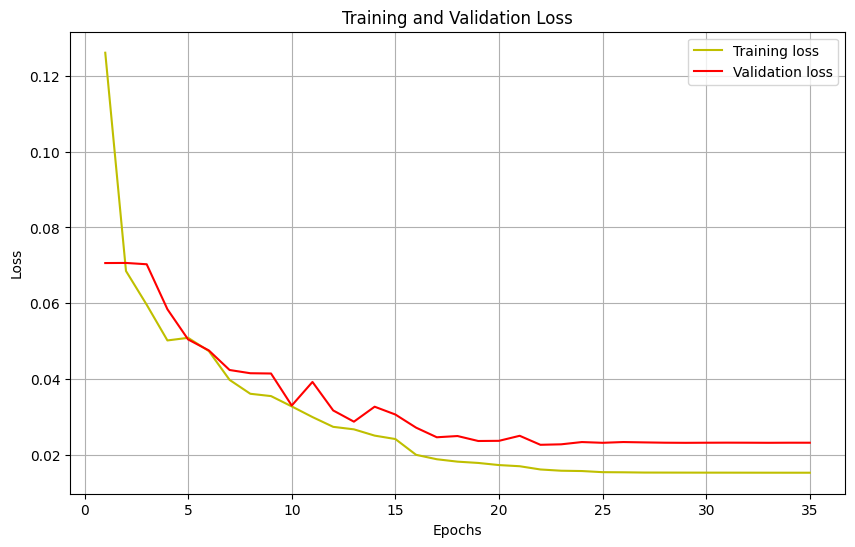

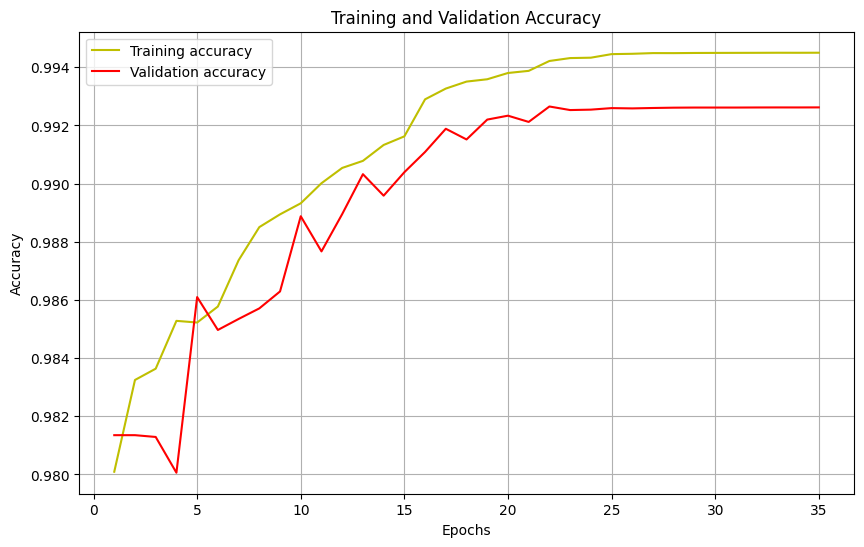

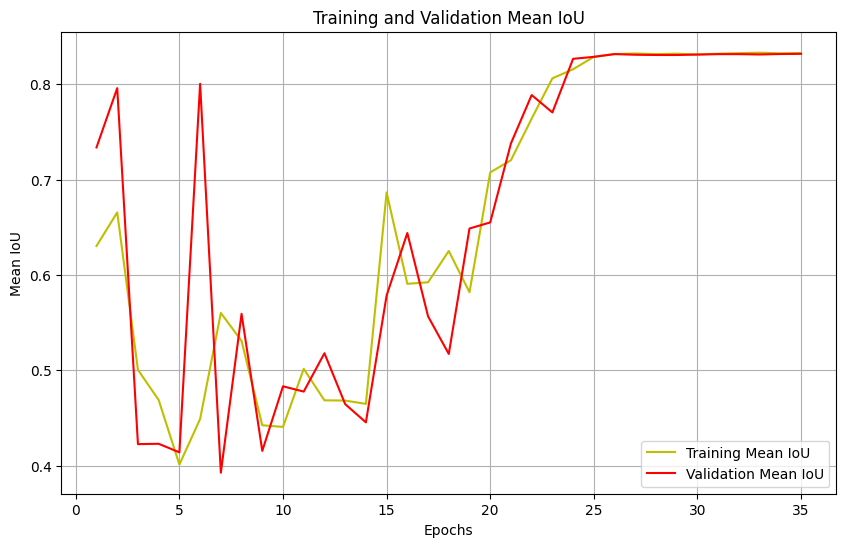

In [22]:
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
acc = history['accuracy']
val_acc = history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation Mean IoU
mean_iou = history['mean_io_u']
val_mean_iou = history['val_mean_io_u'] 

plt.figure(figsize=(10, 6))
plt.plot(epochs, mean_iou, 'y', label='Training Mean IoU')
plt.plot(epochs, val_mean_iou, 'r', label='Validation Mean IoU')
plt.title('Training and Validation Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


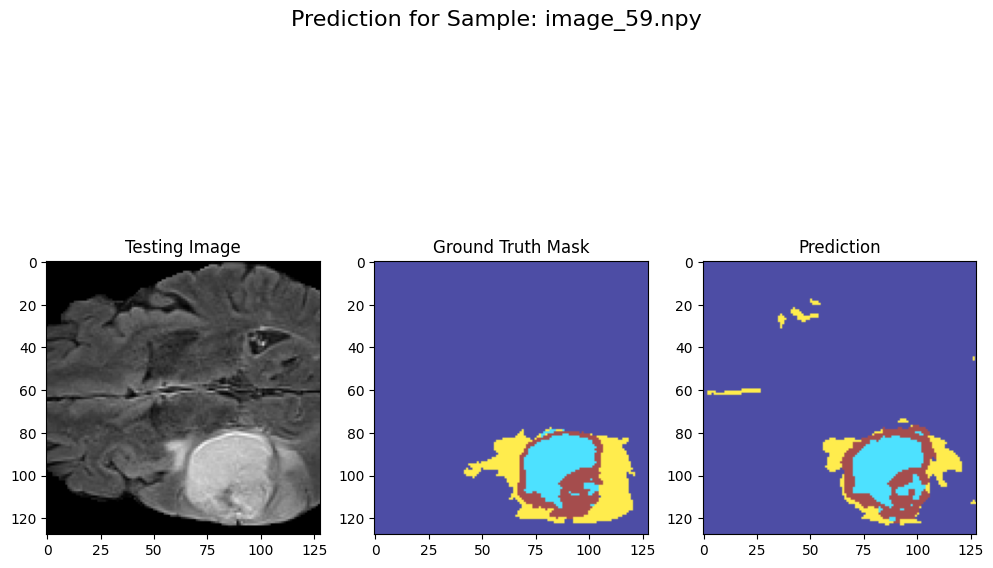

In [27]:
# Load a random test image and mask
files = os.listdir(val_img_dir)

# Choose a random file
random_image_file = random.choice(files)
random_mask_file = random_image_file.replace("image", "mask")

# Load the image and mask
test_img = np.load(os.path.join(val_img_dir, random_image_file))
test_mask = np.load(os.path.join(val_mask_dir, random_mask_file))
test_mask_argmax = np.argmax(test_mask, axis=3) 

# Predict
n_slice = 55  
test_img_slice = test_img[:, :, n_slice, :2]  
test_img_input = np.expand_dims(test_img_slice, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax = np.argmax(test_prediction, axis=-1)[0, :, :]

# Function to visualize the original test image, the ground truth mask, and the model prediction
def showPredicts(test_img, test_mask, test_prediction, sample_name, n_slice=55):
    plt.figure(figsize=(12, 8))

    # Set the main title (heading) above all the subplots
    plt.suptitle(f'Prediction for Sample: {sample_name}', fontsize=16)

    # Original Test Image (FLAIR channel)
    plt.subplot(131)
    plt.title('Testing Image')
    plt.imshow(test_img[:, :, n_slice, 0], cmap='gray')  # Channel 0 = FLAIR

    # Ground Truth Mask
    plt.subplot(132)
    plt.title('Ground Truth Mask')
    plt.imshow(test_mask[:, :, n_slice], cmap="jet", alpha=0.7)

    # Model Prediction
    plt.subplot(133)
    plt.title('Prediction')
    plt.imshow(test_prediction, cmap="jet", alpha=0.7)

    plt.show()

# Call the function to display results
showPredicts(test_img, test_mask_argmax, test_prediction_argmax, sample_name=random_image_file, n_slice=55)